# Estimating Singapore's COVID-19 $R_t$ in Real-Time
_all code originally from Kevin Systrom._

# Import needed libraries

In [1]:
import pandas as pd
import numpy as np
                                                                                                                                                                            
from rt_funcs import *

%config InlineBackend.figure_format = 'retina'

# Application to Singapore

In [2]:
#### From JHU CSSE's covid19 tracker. ####
all_cases = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/"\
                     "time_series_covid19_confirmed_global.csv")

# Get only Singapore
sg_cases = get_cases(all_cases, 'Singapore')


#### My own manual scrape of MOH. ####
most_recent = pd.read_csv("https://docs.google.com/spreadsheets/d/e/"\
                          "2PACX-1vSEsnoFB_UWtY4tM9xPhobtl-L8eY1fW60ba32lUrUn7jVSzRQxeeY-6lH-ogO3nUSHdk1p9PHWUbul/"\
                          "pub?gid=0&single=true&output=csv",
                         index_col=0)

most_recent = most_recent.reindex(pd.to_datetime(most_recent.index))

all_community = pd.concat([sg_cases.loc[:"2020-03-27"].diff(), # Because MOH started segregating numbers after 28 March 2020.
                          most_recent.Community] 
                         )

all_cases = pd.concat([all_community,
                       most_recent.WP_dorm, 
                       most_recent.WP_nondorm], 
                      axis=1)

all_cases.rename(columns={0:"Community"}, inplace=True)

all_cases["All"] = all_cases.sum(axis=1)

In [3]:
# Check the data looks OK.
all_cases

,Community,WP_dorm,WP_nondorm,All
2020-01-22,NaN,NaN,NaN,0.0
2020-01-23,1.0,NaN,NaN,1.0
2020-01-24,2.0,NaN,NaN,2.0
2020-01-25,0.0,NaN,NaN,0.0
2020-01-26,1.0,NaN,NaN,1.0
...,...,...,...,...
2020-04-12,26.0,188.0,19.0,233.0
2020-04-13,39.0,333.0,14.0,386.0
2020-04-14,40.0,277.0,17.0,334.0
2020-04-15,37.0,406.0,4.0,447.0


In [4]:
# Process data for each group

all_data_for_plot = {}

for j, group in enumerate(all_cases.columns):
    print(j+1, group)
    
    if group.startswith("WP"):
        WINSIZE = 4 # days for smoothing window.
    else:
        WINSIZE = 7
        
    all_data_for_plot[group] = process_data(all_cases[group], winsize=WINSIZE)
    
    print(f"{group} processed.")

1 Community
Community processed.
2 WP_dorm
WP_dorm processed.
3 WP_nondorm
WP_nondorm processed.
4 All
All processed.


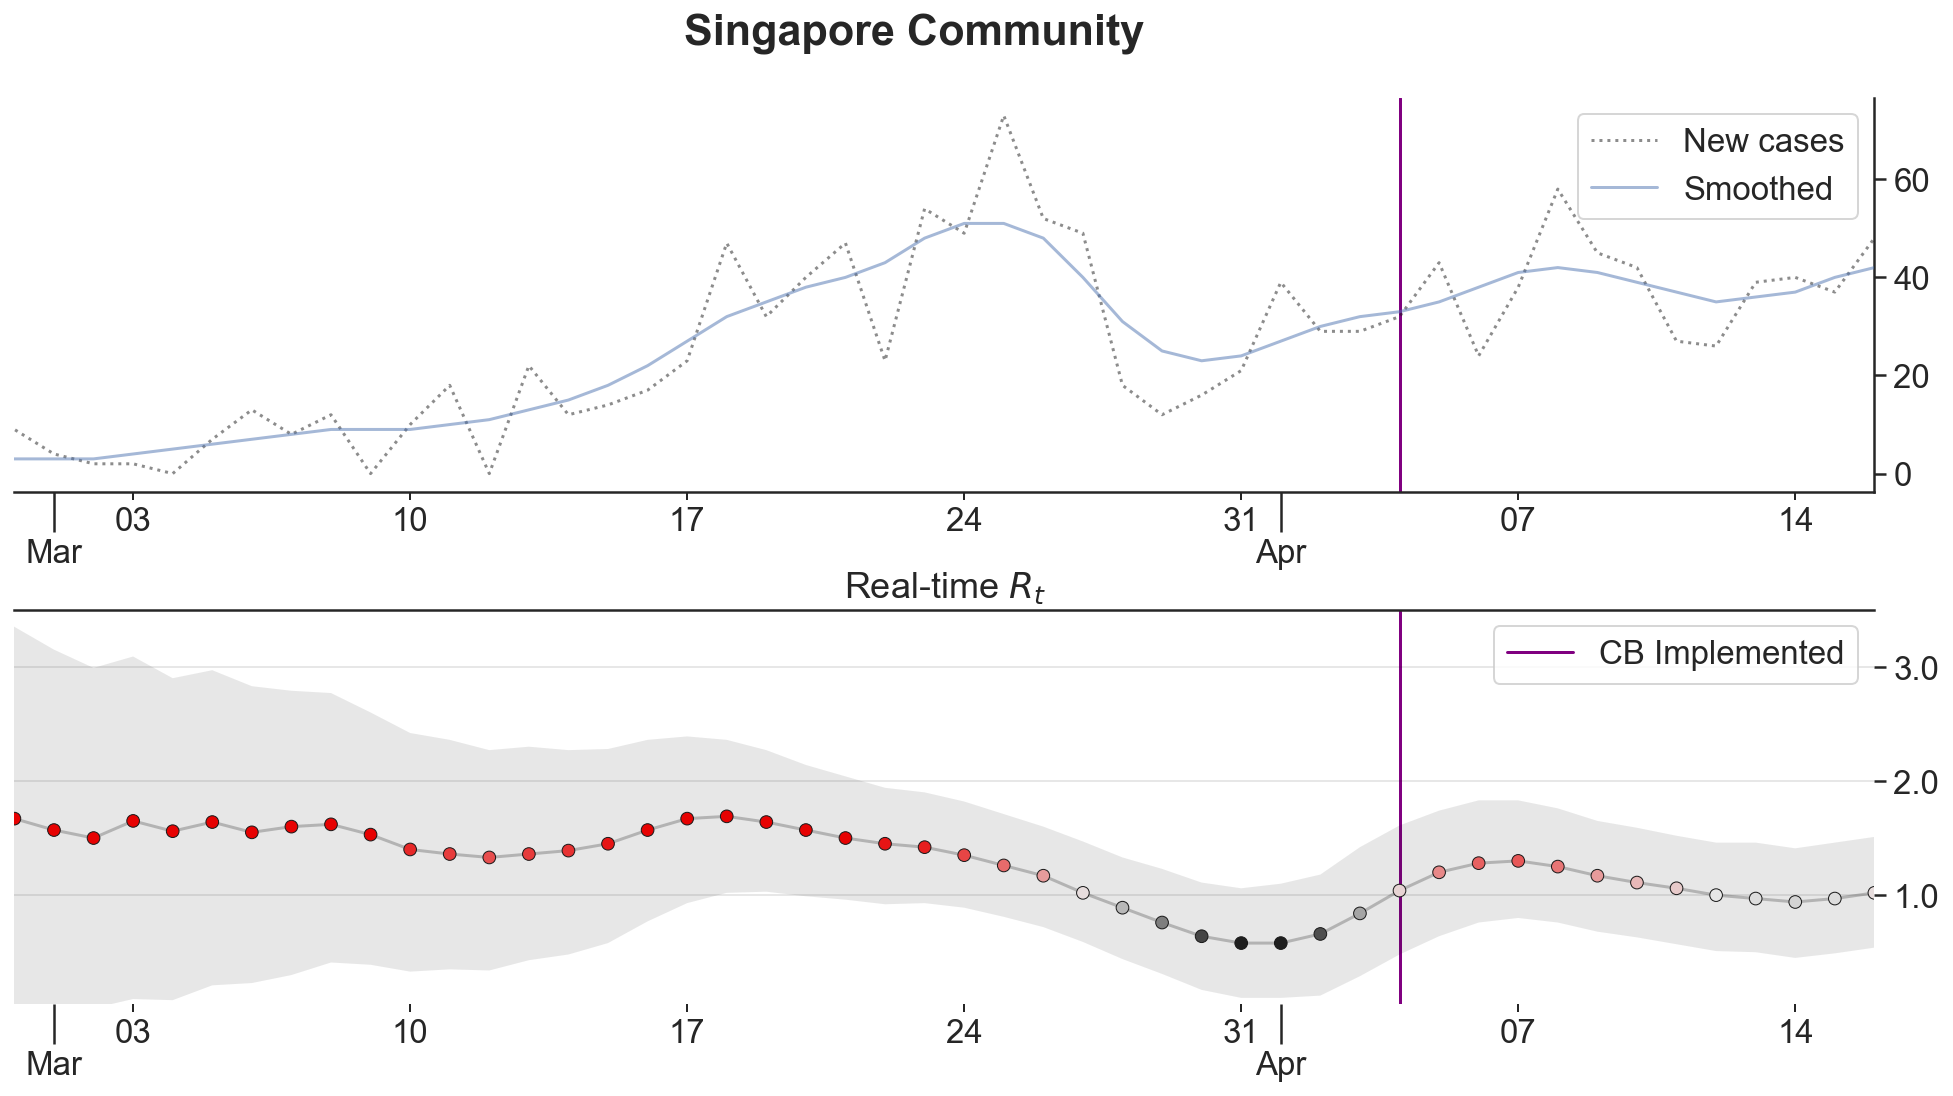

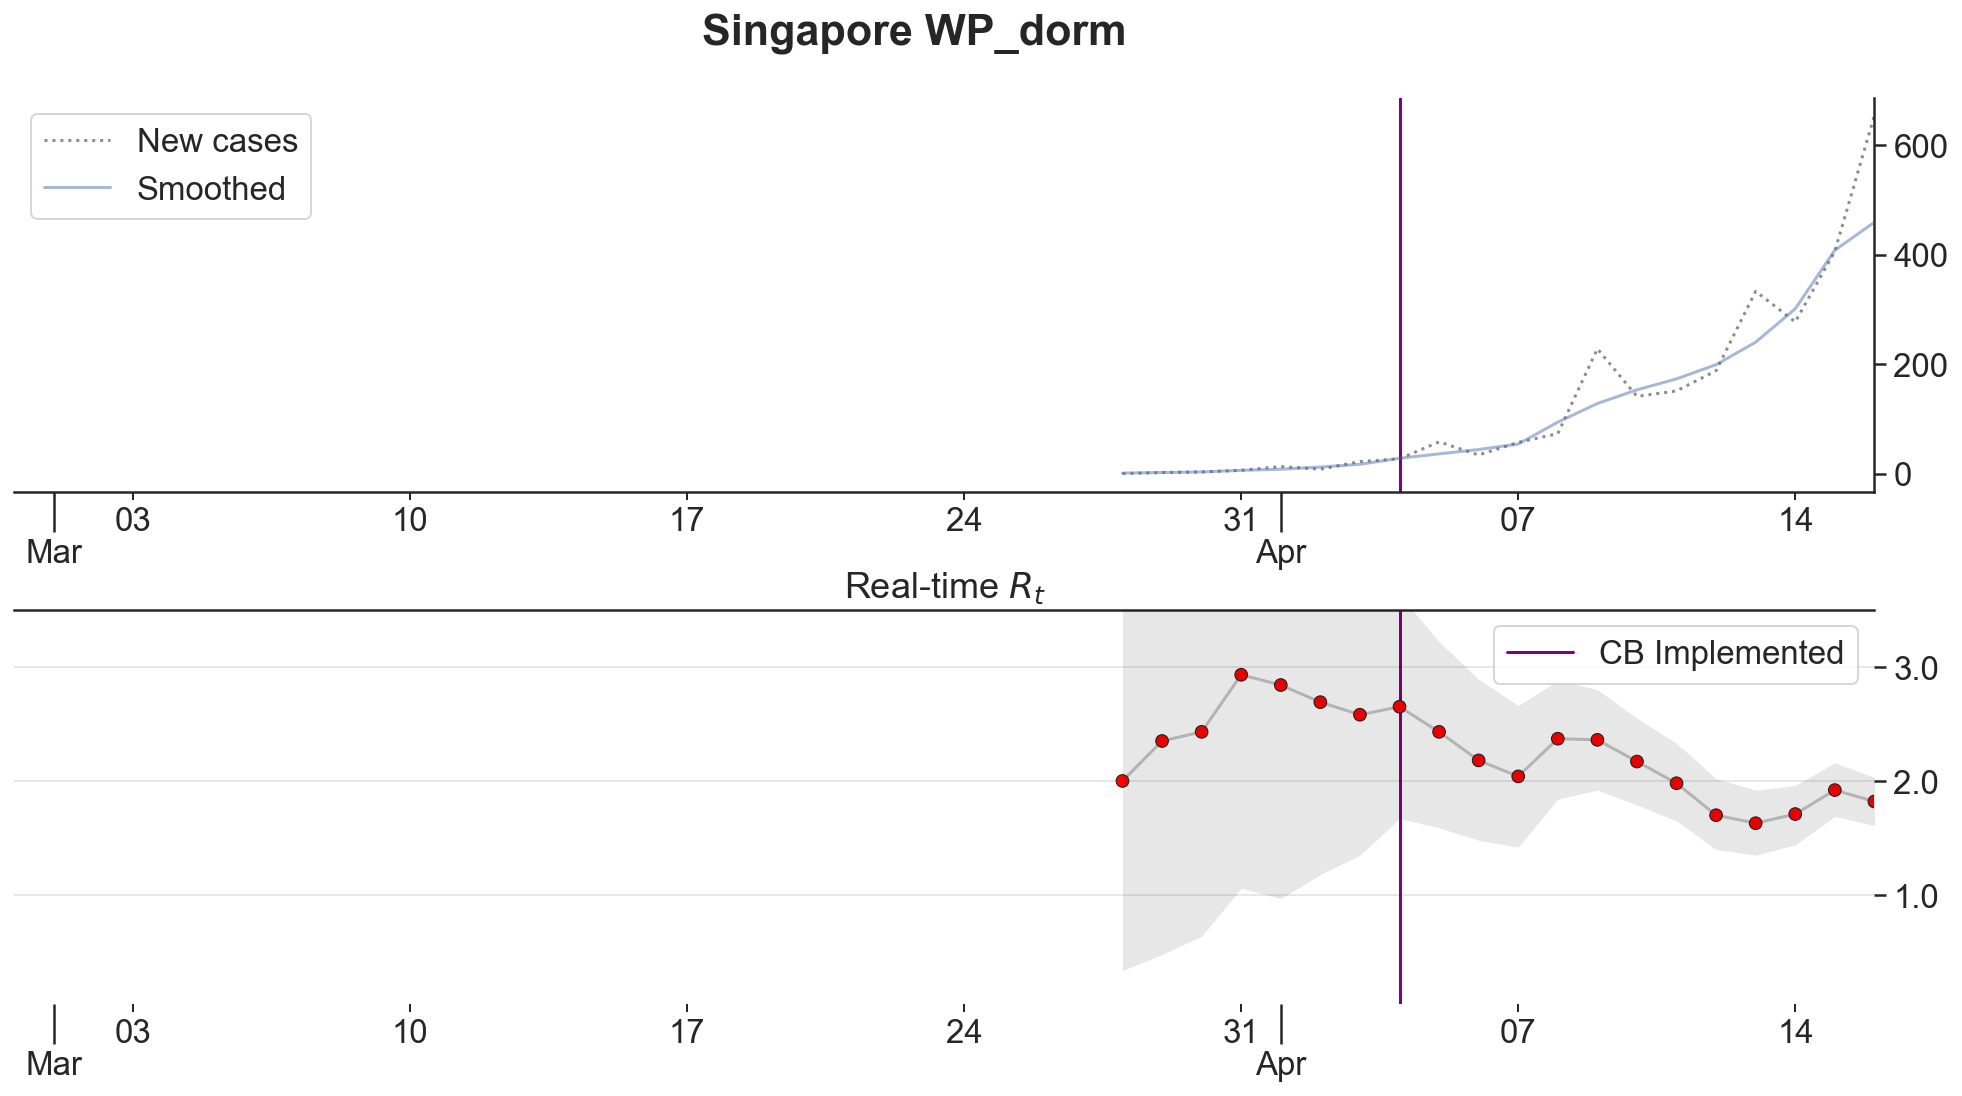

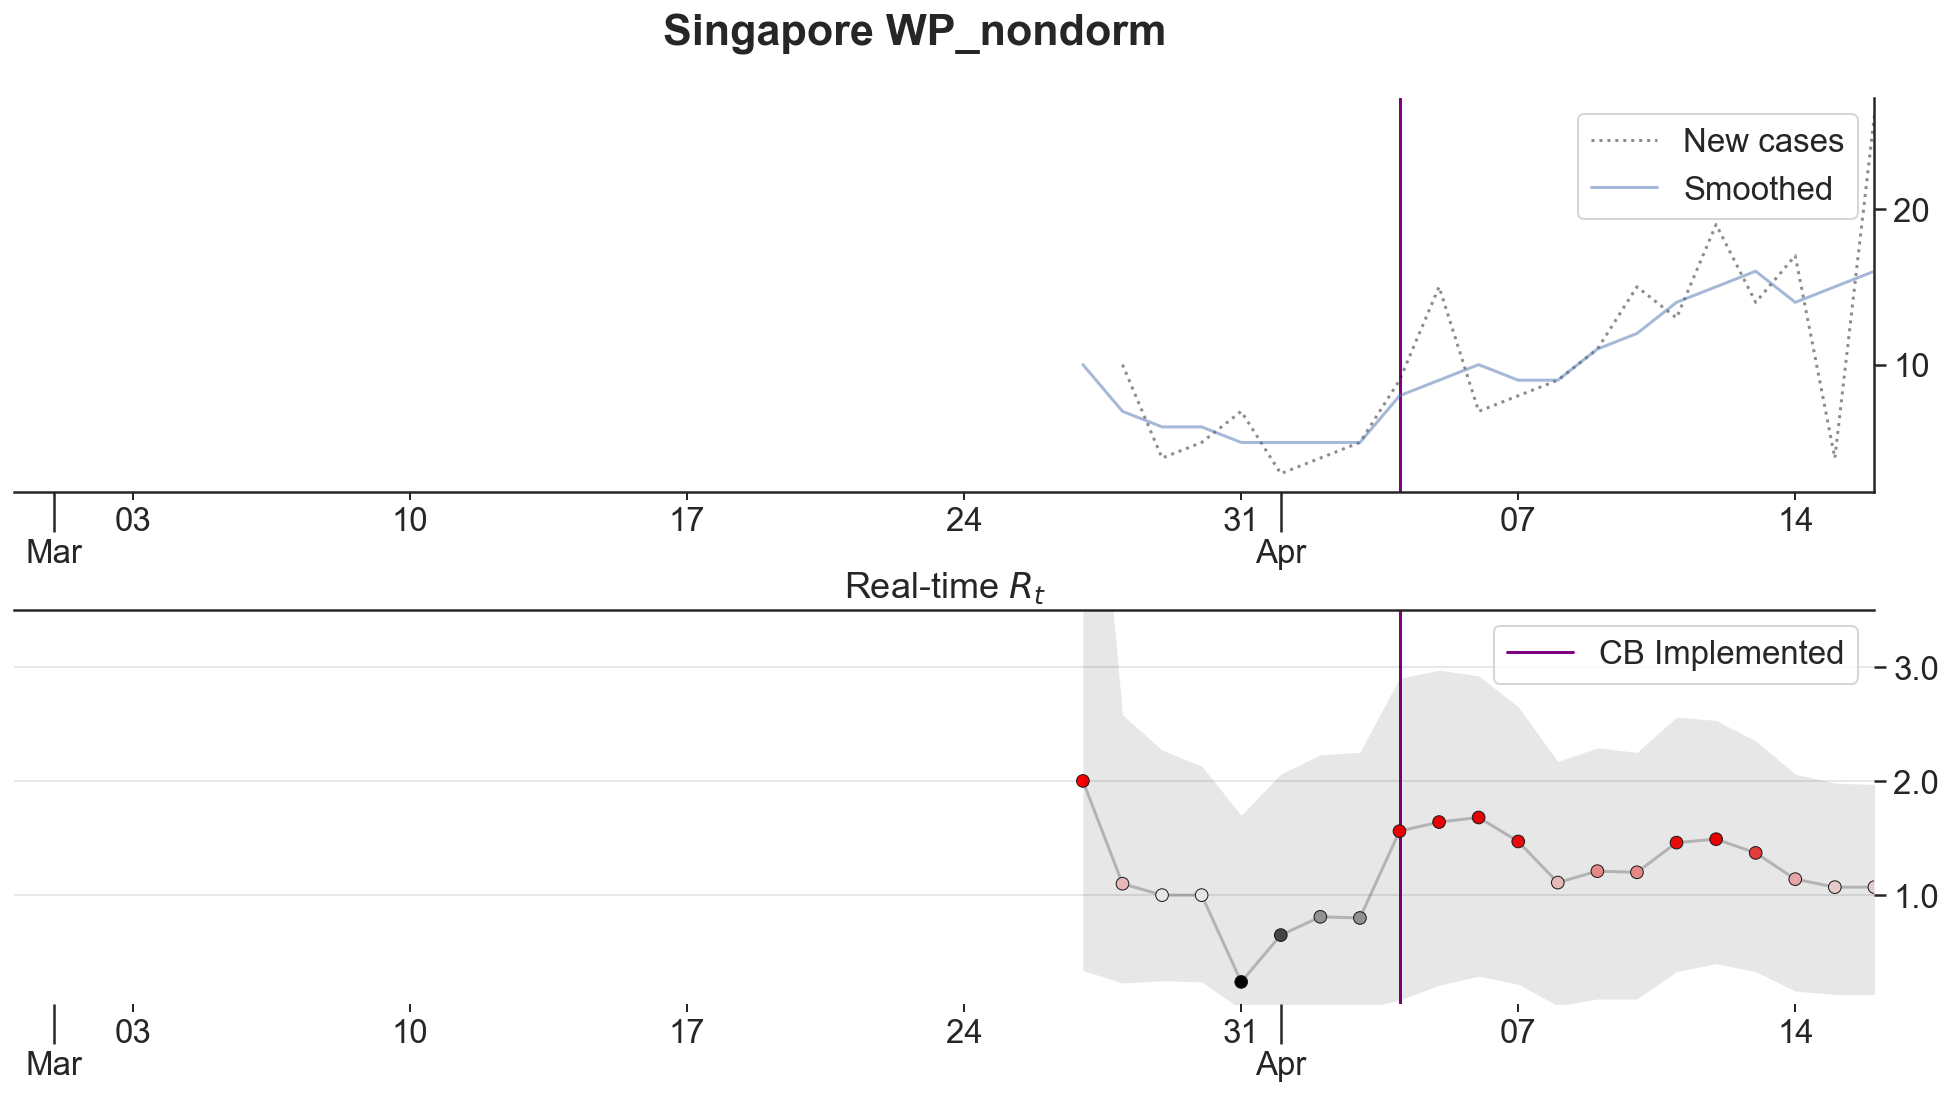

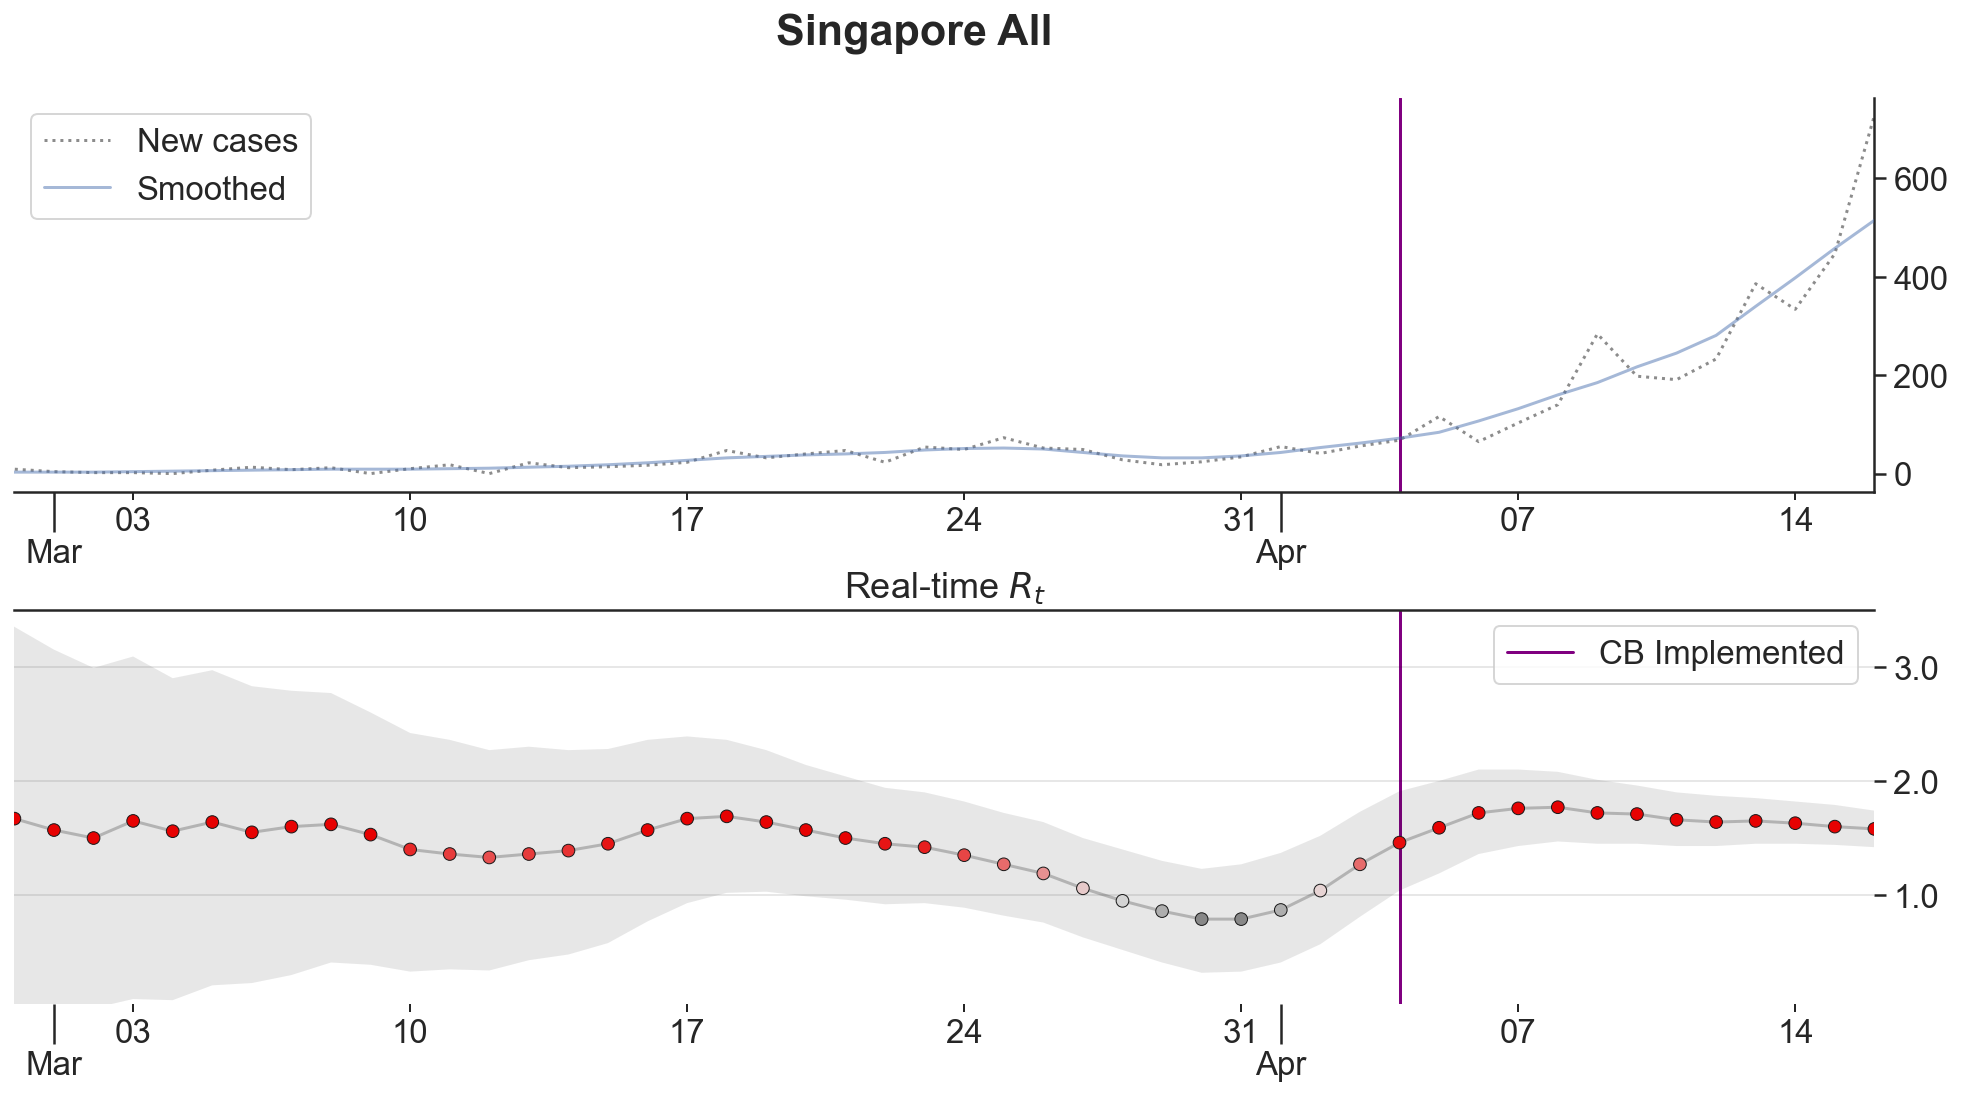

In [6]:
# Create plot.
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

sns.set(font_scale=1.5, style="ticks")

for j, key in enumerate(all_data_for_plot.keys()):
    
    DATA = all_data_for_plot[key]
    raw = DATA['raw']
    smoothed = DATA['smoothed']
    rt = DATA['rt']
    
    f, axx = plt.subplots(nrows=2, figsize = (1200/72, 600/72),
                         gridspec_kw={"hspace": 0.3})
    

    f.suptitle(f'Singapore {key}', y=0.95, fontweight='bold')
    # Plot the data.
    
    axx[0].plot(raw.index, raw.values, linestyle=":", color='k', 
            zorder=5, alpha=.5, label="New cases")
    
    axx[0].plot(smoothed.index, smoothed.values, color='b',
            zorder=7, alpha=.5, label="Smoothed")
    
    axx[0].legend()
    
    sns.despine(ax=axx[0], right=False, left=True)
        
 
    plot_rt(rt, axx[1], "")
    
    axx[1].set_title(f'Real-time $R_t$')
    axx[1].set_ylim(.05, 3.5)  
    
    for a in axx:
#         a.set_xlim(all_cases.index[0], all_cases.index[-1])
        a.set_xlim(pd.Timestamp("2020-02-29"), 
                   all_cases.index[-1])
        a.tick_params(axis='x', which='major', length=20)
        
        a.xaxis.set_major_locator(mdates.MonthLocator())
        a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        
        a.xaxis.set_minor_locator(mdates.WeekdayLocator())
        a.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
        
        a.axvline(x=pd.Timestamp('2020-04-04'), color='purple', label='CB Implemented',
                 zorder=0)
#         
    axx[1].legend()
